# <span style="background-color:white;color:red;"> ⌛⌛ EN PROGRESO⌛⌛</span>

## Bloque I
Descomprimir el csv en formato gz

In [2]:
"""  
Importación de ficheros de AIRBNB. Preprocesado y cargado a la base de datos 

Obtenemos los datos desde https://insideairbnb.com/get-the-data/

Podríamos hacer scraping, obtener la fecha de la última actualización de Madrid y generar el enlace para descargarlo, pero no es necesario por que se actualiza cada mucho tiempo y no es necesario tener la última versión. Podemos cambiar la info procesable en la carpeta data manualmente.

"""
import os
import pandas as pd
import numpy as np
import datetime
from config_bd import *
import requests
import sys
import gzip
import shutil

DATA_DIR = os.path.join('data')
# DATA_DIR = os.path.join(os.path.dirname(__file__), 'data')
TEMP_DIR = os.path.join(DATA_DIR, 'TEMP')


""" Comprobamos que existe el directorio de datos """

if not os.path.exists(DATA_DIR):
    print(f"El directorio {DATA_DIR} no existe. No es posible continuar...")
    sys.exit()

""" Descomprimimos el archivo de calendario """

if not os.path.exists(TEMP_DIR):
    os.makedirs(TEMP_DIR)


gz_file_path = os.path.join(DATA_DIR, 'listings.csv.gz')
output_file_path = os.path.join(TEMP_DIR, os.path.splitext(os.path.basename(gz_file_path))[0])

if os.path.exists(gz_file_path):
    try:
        with gzip.open(gz_file_path, 'rb') as f_in:
            with open(output_file_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print(f"Archivo {gz_file_path} descomprimido como {output_file_path}")
    except Exception as e:
        print(f"Error al descomprimir el archivo {gz_file_path}: {e}")
        sys.exit()
else:
    print(f"El archivo {gz_file_path} no existe. No es posible continuar...")
    sys.exit()


Archivo data\listings.csv.gz descomprimido como data\TEMP\listings.csv


## Bloque II
Carga del csv de detalle completo en pandas. Cambios de tipos e imputación

Estos son lo pasos seguidos:

<ul>
<li>Eliminamos campos innecesarios</li>
<li>Eliminamos las propiedades que no se encuentran dentro del perímetro de interés (habitaciones, compartidas, albergues...)</li>
<li></li>
<li></li>
<li></li>
<li></li>
<li></li>
</ul>

In [3]:
df = pd.read_csv(output_file_path, low_memory=False)

In [4]:
df
df['aire'] = df['amenities'].apply(lambda x: 1 if '"Air conditioning"' in x else 0)
df['garaje'] = df['amenities'].apply(lambda x: 1 if 'free parking' in x.lower() else 0)
df['calefaccion'] = df['amenities'].apply(lambda x: 1 if '"Heating"' in x else 0)
df['ascensor'] = df['amenities'].apply(lambda x: 1 if '"Elevator"' in x else 0)

In [5]:
df

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,aire,garaje,calefaccion,ascensor
0,21853,https://www.airbnb.com/rooms/21853,20250305023340,2025-03-11,city scrape,Bright and airy room,We have a quiet and sunny room with a good vie...,We live in a leafy neighbourhood with plenty o...,https://a0.muscache.com/pictures/68483181/87bc...,83531,...,f,2,0,2,0,0.26,1,1,1,1
1,30320,https://www.airbnb.com/rooms/30320,20250305023340,2025-03-10,previous scrape,Great Vacational Apartments,NaN,NaN,https://a0.muscache.com/pictures/336868/f67409...,130907,...,f,3,3,0,0,0.96,1,0,1,1
2,30959,https://www.airbnb.com/rooms/30959,20250305023340,2025-03-10,previous scrape,Beautiful loft in Madrid Center,Beautiful Loft 60m2 size just in the historica...,NaN,https://a0.muscache.com/pictures/78173471/835e...,132883,...,f,1,1,0,0,0.07,0,0,1,1
3,40916,https://www.airbnb.com/rooms/40916,20250305023340,2025-03-10,previous scrape,Holiday Apartment Madrid Center,NaN,NaN,https://a0.muscache.com/pictures/336736/c3b486...,130907,...,f,3,3,0,0,0.28,1,0,1,1
4,62423,https://www.airbnb.com/rooms/62423,20250305023340,2025-03-12,city scrape,MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID,INCREDIBLE HOME OF AN ARTIST SURROUNDED BY PAI...,DISTRICT WITH VERY GOOD VIBES IN THE MIDDLE OF...,https://a0.muscache.com/pictures/miso/Hosting-...,303845,...,f,3,1,2,0,2.73,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25283,1368985680426539467,https://www.airbnb.com/rooms/1368985680426539467,20250305023340,2025-03-12,city scrape,Acogedor y nuevo ático con gran terraza (B),"Cozy penthouse floor with large terrace, locat...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,20803102,...,f,3,3,0,0,NaN,1,0,1,1
25284,1368986418960986344,https://www.airbnb.com/rooms/1368986418960986344,20250305023340,2025-03-05,city scrape,Elegante apartamento en Madrid!,Have fun with the whole family at this stylish...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,52530675,...,f,45,45,0,0,NaN,1,0,0,0
25285,1368991577357063431,https://www.airbnb.com/rooms/1368991577357063431,20250305023340,2025-03-10,city scrape,Tropical apartment Madrid,Get away from routine at this unique and relax...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,52530675,...,f,45,45,0,0,NaN,1,0,0,0
25286,1369034696848967860,https://www.airbnb.com/rooms/1369034696848967860,20250305023340,2025-03-07,city scrape,"Cama 1 de 04, no es hinchable.",Enjoy the comfort and tranquility of this home.,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,543251626,...,f,4,0,0,4,NaN,0,0,0,0


In [6]:
df[df['garaje']==1]

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,aire,garaje,calefaccion,ascensor
0,21853,https://www.airbnb.com/rooms/21853,20250305023340,2025-03-11,city scrape,Bright and airy room,We have a quiet and sunny room with a good vie...,We live in a leafy neighbourhood with plenty o...,https://a0.muscache.com/pictures/68483181/87bc...,83531,...,f,2,0,2,0,0.26,1,1,1,1
20,100411,https://www.airbnb.com/rooms/100411,20250305023340,2025-03-10,previous scrape,Ático muy luminoso,Penthouse with a beautiful terrace and expansi...,"Very well connected residential area, with a l...",https://a0.muscache.com/pictures/673487/3c41ea...,527760,...,f,1,1,0,0,0.03,0,1,1,1
23,136058,https://www.airbnb.com/rooms/136058,20250305023340,2025-03-05,city scrape,"Calm, affordable room in Madrid.","The apartment is located in a safe, quiet and ...","The neighborhood is quiet, beautiful, safe and...",https://a0.muscache.com/pictures/85a31ad7-2224...,666482,...,f,1,0,1,0,0.58,0,1,1,1
25,167183,https://www.airbnb.com/rooms/167183,20250305023340,2025-03-12,city scrape,private house B & B. Arturo Soria (Metro),"Residential area, very quite house, no more gu...","The best location in Arturo Soria, next to Par...",https://a0.muscache.com/pictures/3458309/73f62...,796746,...,f,2,0,2,0,0.29,1,1,1,0
38,689099,https://www.airbnb.com/rooms/689099,20250305023340,2025-03-07,previous scrape,Lujo a tu alcance,"A quiet room, without the crowds of downtown, ...",A very quiet area. We have several cafes-resta...,https://a0.muscache.com/pictures/54356813-b2d7...,3357259,...,f,1,0,1,0,0.10,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25238,1368304377290123314,https://www.airbnb.com/rooms/1368304377290123314,20250305023340,2025-03-11,city scrape,Cómoda habitación doble,Comfortable room with 150 cm bed and built-in ...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,368390948,...,f,1,0,1,0,1.00,1,1,1,1
25239,1368305303631228330,https://www.airbnb.com/rooms/1368305303631228330,20250305023340,2025-03-05,city scrape,"Habitación, Ensanche de Vallecas",Quiet accommodation to spend your days in Madr...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,416541176,...,f,1,0,1,0,NaN,1,1,0,0
25240,1368313760167698062,https://www.airbnb.com/rooms/1368313760167698062,20250305023340,2025-03-12,city scrape,"Chamartín, Vive Madrid.",Welcome to your home away from home!<br />This...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,681979786,...,t,1,1,0,0,NaN,1,1,0,0
25253,1366584727244034857,https://www.airbnb.com/rooms/1366584727244034857,20250305023340,2025-03-12,city scrape,"2. Estudio con Baño,Cocina privada y Aire acon...","Private studio. With a private bathroom, washi...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,490812264,...,t,17,17,0,0,NaN,1,1,0,0


Eliminamos campos innecesarios

In [7]:
df = df.drop(columns=['scrape_id','last_scraped','source','neighborhood_overview','host_id','host_url','host_name','host_since','host_location','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost','host_thumbnail_url','host_picture_url','host_listings_count','host_total_listings_count','host_verifications','host_has_profile_pic','host_identity_verified','neighbourhood','bathrooms_text','beds','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','has_availability','calendar_last_scraped','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','availability_eoy','number_of_reviews_ly','first_review','last_review','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','license','instant_bookable','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month','host_about','host_neighbourhood','calendar_updated','availability_30','availability_60','availability_90','availability_365','picture_url'])

Eliminamos las habitaciones, casas compartidas, hoteles, picaderos, etc, solo queremos viviendas completas

In [8]:
# df['property_type'].value_counts()
# df['room_type'].value_counts()
df = df[df['room_type']== 'Entire home/apt'].copy()
df['room_type'].value_counts()

room_type
Entire home/apt    16805
Name: count, dtype: int64

conversión de tipos

In [9]:
df['accommodates'] = df['accommodates'].astype(int)
df['bathrooms'] = df['bathrooms'].replace([np.inf,-np.inf],np.nan).fillna(0).astype(int)
df['bedrooms'] = df['bedrooms'].replace([np.inf,-np.inf],np.nan).fillna(0).astype(int)
df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df['minimum_nights'] = df['minimum_nights'].astype(int)
df['maximum_nights'] = df['maximum_nights'].astype(int)
df['estimated_occupancy_l365d'] = df['estimated_occupancy_l365d'].astype(int)

imputamos una habitación y un baño cuando esta información no está rellena, asumiendo que habiendo retirado las propiedades compartidas, podemos interpretar que los estudios, lofts, etc todos van a tener al menos una habitación y baño o equivalente. (Sofá cama, etc).

*También se podría imputar las habitaciones dividiendo los "acommodates" entre dos pero creo que este método es más conservador.*

In [10]:
df[df['bathrooms']==0]

,id,listing_url,name,description,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,...,amenities,price,minimum_nights,maximum_nights,estimated_occupancy_l365d,estimated_revenue_l365d,aire,garaje,calefaccion,ascensor
1,30320,https://www.airbnb.com/rooms/30320,Great Vacational Apartments,NaN,Sol,Centro,40.414760,-3.704180,Entire rental unit,Entire home/apt,...,"[""Kitchen"", ""Air conditioning"", ""Elevator"", ""T...",NaN,5,180,0,NaN,1,0,1,1
2,30959,https://www.airbnb.com/rooms/30959,Beautiful loft in Madrid Center,Beautiful Loft 60m2 size just in the historica...,Embajadores,Centro,40.412590,-3.701050,Entire loft,Entire home/apt,...,"[""Shampoo"", ""Smoking allowed"", ""Pets allowed"",...",NaN,3,730,0,NaN,0,0,1,1
3,40916,https://www.airbnb.com/rooms/40916,Holiday Apartment Madrid Center,NaN,Universidad,Centro,40.422470,-3.705770,Entire rental unit,Entire home/apt,...,"[""Pets allowed"", ""Kitchen"", ""TV"", ""Air conditi...",NaN,5,180,0,NaN,1,0,1,1
8,82481,https://www.airbnb.com/rooms/82481,"Retiro Park, Stay at cosy studio","Studio inside house, but independent from it. ...",Recoletos,Salamanca,40.423420,-3.681230,Entire rental unit,Entire home/apt,...,"[""Hangers"", ""Wifi"", ""Essentials"", ""Shampoo"", ""...",NaN,3,365,0,NaN,0,0,1,1
13,599134,https://www.airbnb.com/rooms/599134,Cosy Plaza Mayor apartment in central Madrid,Cosy apartment in central location.,Sol,Centro,40.415960,-3.708460,Entire condo,Entire home/apt,...,"[""Hangers"", ""Kitchen"", ""Hair dryer"", ""TV"", ""Ex...",NaN,30,365,0,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24745,1354584586110919472,https://www.airbnb.com/rooms/1354584586110919472,# #StudioPlazaCastiilla/wifi/A/C,"Cozy one bedroom apartment, short walk to Vald...",Valdeacederas,Tetuán,40.467468,-3.706808,Entire home,Entire home/apt,...,"[""Air conditioning"", ""Iron"", ""Wifi"", ""Cooking ...",NaN,1,365,12,NaN,1,0,1,0
24746,1354593678560108749,https://www.airbnb.com/rooms/1354593678560108749,# # #StudioPlazaCastilla/Wifi/,"Cozy one-bedroom apartment is rented, a short ...",Valdeacederas,Tetuán,40.465700,-3.705790,Entire home,Entire home/apt,...,"[""Portable fans"", ""Air conditioning"", ""Iron"", ...",NaN,1,365,0,NaN,1,0,1,0
24756,1356479961817596937,https://www.airbnb.com/rooms/1356479961817596937,Madrid City Center Cozy Apartment,"This special place is close to everything, mak...",Justicia,Centro,40.424576,-3.696638,Entire condo,Entire home/apt,...,"[""Hangers"", ""Shampoo"", ""Self check-in"", ""Kitch...",85.0,2,365,0,0.0,0,0,1,0
24815,1355643402448451349,https://www.airbnb.com/rooms/1355643402448451349,apartamento con piscina y garaje,Discover comfort and style in this modern new-...,San Andrés,Villaverde,40.333596,-3.701003,Entire rental unit,Entire home/apt,...,"[""Smart lock"", ""Self check-in"", ""Air condition...",NaN,1,1125,0,NaN,1,0,1,1


In [11]:
# df[(df['bathrooms'] == 0)& (df['bedrooms']==0)]
df['bathrooms'] = df['bathrooms'].replace(0,1)
df['bedrooms'] = df['bedrooms'].replace(0,1)

In [12]:
df = df.rename(columns={'id':'property_id'})

In [14]:
df = df.dropna(subset=['price'])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13871 entries, 5 to 25285
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   property_id                   13871 non-null  int64  
 1   listing_url                   13871 non-null  object 
 2   name                          13871 non-null  object 
 3   description                   13510 non-null  object 
 4   neighbourhood_cleansed        13871 non-null  object 
 5   neighbourhood_group_cleansed  13871 non-null  object 
 6   latitude                      13871 non-null  float64
 7   longitude                     13871 non-null  float64
 8   property_type                 13871 non-null  object 
 9   room_type                     13871 non-null  object 
 10  accommodates                  13871 non-null  int64  
 11  bathrooms                     13871 non-null  int64  
 12  bedrooms                      13871 non-null  int64  
 13  amenit

## Bloque III
Importamos a la base de datos. 
**Requiere haber creado la tabla** <code>01_CREATE TABLE bnb_property.sql</code>

In [16]:
from config_bd import get_connection

In [17]:
df.to_csv(os.path.join(TEMP_DIR,'transform_listings.csv'), index=False)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13871 entries, 5 to 25285
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   property_id                   13871 non-null  int64  
 1   listing_url                   13871 non-null  object 
 2   name                          13871 non-null  object 
 3   description                   13510 non-null  object 
 4   neighbourhood_cleansed        13871 non-null  object 
 5   neighbourhood_group_cleansed  13871 non-null  object 
 6   latitude                      13871 non-null  float64
 7   longitude                     13871 non-null  float64
 8   property_type                 13871 non-null  object 
 9   room_type                     13871 non-null  object 
 10  accommodates                  13871 non-null  int64  
 11  bathrooms                     13871 non-null  int64  
 12  bedrooms                      13871 non-null  int64  
 13  amenit

# ⌛VOY POR AQUÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍÍ

In [12]:
# from tqdm import tqdm
# # from time import sleep

# with get_connection() as conn:
#     cursor = conn.cursor()
#     cursor.fast_executemany = True 

#     CHUNKSIZE = 500
#     for chunk in tqdm(
#         pd.read_csv(os.path.join(TEMP_DIR, 'transform_calendar.csv'), chunksize=CHUNKSIZE),
#         unit_scale=CHUNKSIZE, unit=" filas"
#     ):

#         insert_sql = """
#         INSERT INTO dbo.bnb_calendar
#             (property_id, [date], available, price,
#             minimum_nights, maximum_nights)
#         VALUES (?,?,?,?,?,?)
#         """
#         cursor.executemany(insert_sql, chunk.values.tolist())
#         conn.commit()        




~~Elimino el fichero para no dejar duplicado el csv~~
<span style="color:orange">En este notebook no hay que eliminar el transformado ya que lo vamos a emplear desde el notebook de calendars, evitando importar a la base de datos la información que no nos interesa respecto a las viviendas que hemos eliminado.</span>

In [13]:
# os.remove(os.path.join(TEMP_DIR,'transform_listings.csv'))

In [14]:
df = pd.read_csv(os.path.join(TEMP_DIR,'transform_listings.csv'))

In [15]:
# df['id'].max()
# df['neighbourhood_cleansed'].value_counts()
df['neighbourhood_group_cleansed'].value_counts()

neighbourhood_group_cleansed
Centro                   7892
Salamanca                1325
Tetuán                   1124
Chamberí                 1118
Arganzuela                861
Retiro                    615
Chamartín                 614
Carabanchel               439
Ciudad Lineal             434
Puente de Vallecas        410
Moncloa - Aravaca         371
Latina                    301
Hortaleza                 294
Usera                     276
San Blas - Canillejas     265
Fuencarral - El Pardo     175
Villaverde                 97
Barajas                    70
Villa de Vallecas          60
Moratalaz                  40
Vicálvaro                  24
Name: count, dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16805 entries, 0 to 16804
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   property_id                   16805 non-null  int64  
 1   listing_url                   16805 non-null  object 
 2   name                          16805 non-null  object 
 3   description                   16344 non-null  object 
 4   neighbourhood_cleansed        16805 non-null  object 
 5   neighbourhood_group_cleansed  16805 non-null  object 
 6   latitude                      16805 non-null  float64
 7   longitude                     16805 non-null  float64
 8   property_type                 16805 non-null  object 
 9   room_type                     16805 non-null  object 
 10  accommodates                  16805 non-null  int64  
 11  bathrooms                     16805 non-null  int64  
 12  bedrooms                      16805 non-null  int64  
 13  p

In [21]:
df['calc'] = df['price'] * df['estimated_occupancy_l365d']

In [23]:
df.groupby(['neighbourhood_group_cleansed']).agg({'estimated_occupancy_l365d':'mean'}).sort_values('neighbourhood_group_cleansed', ascending=False).reset_index()

,neighbourhood_group_cleansed,estimated_occupancy_l365d
0,Villaverde,57.618557
1,Villa de Vallecas,82.933333
2,Vicálvaro,110.125000
3,Usera,75.369565
4,Tetuán,75.396797
5,San Blas - Canillejas,80.766038
6,Salamanca,81.688302
7,Retiro,84.141463
8,Puente de Vallecas,78.997561
9,Moratalaz,107.475000


In [22]:
df.sort_values(by="estimated_revenue_l365d",ascending=False).head(10)

,property_id,listing_url,name,description,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,price,minimum_nights,maximum_nights,estimated_occupancy_l365d,estimated_revenue_l365d,calc
11667,1087700981397177073,https://www.airbnb.com/rooms/1087700981397177073,Stunning duplex | Terrace & BBQ | Free Parking,Discover our duplex in the North Zone of Madri...,Valdeacederas,Tetuán,40.467680,-3.708650,Entire rental unit,Entire home/apt,6,2,2,23124.0,3,365,114,2636136.0,2636136.0
1701,18816591,https://www.airbnb.com/rooms/18816591,PUERTA DEL ANGEL,"Located next to Paseo De Extremadura, a few me...",Puerta del Angel,Latina,40.409160,-3.732560,Entire rental unit,Entire home/apt,4,1,1,19276.0,3,365,102,1966152.0,1966152.0
6248,577960547451462595,https://www.airbnb.com/rooms/577960547451462595,Luxury La Latina,"Steps away from the royal palace, the Cebada m...",Palacio,Centro,40.409010,-3.713490,Entire rental unit,Entire home/apt,4,1,2,2251.0,1,730,255,574005.0,574005.0
9362,918580151552814707,https://www.airbnb.com/rooms/918580151552814707,Cozy apartment with balconies in Chueca,Welcome to this beautiful Airbnb apartment in ...,Justicia,Centro,40.423673,-3.699559,Entire rental unit,Entire home/apt,2,1,1,6517.0,3,365,84,547428.0,547428.0
5431,50995991,https://www.airbnb.com/rooms/50995991,Cozy and central studio - Puerta del Sol,"Cozy studio, renovated, with a careful design ...",Sol,Centro,40.419110,-3.705490,Entire rental unit,Entire home/apt,2,1,1,2069.0,1,1125,210,434490.0,434490.0
1509,17932739,https://www.airbnb.com/rooms/17932739,Bright & Spacious 2BD 2BTH - Las Letras,Spacious and bright apartment located in the B...,Cortes,Centro,40.412890,-3.696620,Entire rental unit,Entire home/apt,6,2,2,1302.0,1,1125,255,332010.0,332010.0
6003,54408298,https://www.airbnb.com/rooms/54408298,Modern & Bright - 2Bedrooms 1.5Baths -Plaza Es...,Bright apartment located in the heart of Madri...,Argüelles,Moncloa - Aravaca,40.426060,-3.715450,Entire rental unit,Entire home/apt,5,1,2,3420.0,1,1125,96,328320.0,328320.0
14249,1236338692469671335,https://www.airbnb.com/rooms/1236338692469671335,Luxury Jerónimos,This brand new unique apartment is located in ...,Jerónimos,Retiro,40.418493,-3.691579,Entire rental unit,Entire home/apt,6,3,3,1174.0,20,365,240,281760.0,281760.0
4965,46653997,https://www.airbnb.com/rooms/46653997,LUXURY PENTHOUSE. TERRACE + SWIMMING POOL,Penthouse decorated in detail with high qualit...,Hellín,San Blas - Canillejas,40.433160,-3.619620,Entire condo,Entire home/apt,4,1,1,1000.0,2,1000,255,255000.0,255000.0
4471,42595353,https://www.airbnb.com/rooms/42595353,Luxury Penthouse W/Terrace - 5BD 5BTH - Gran vía,Luxury penthouse in historic building located ...,Justicia,Centro,40.420440,-3.697180,Entire rental unit,Entire home/apt,10,5,5,1545.0,1,1125,150,231750.0,231750.0


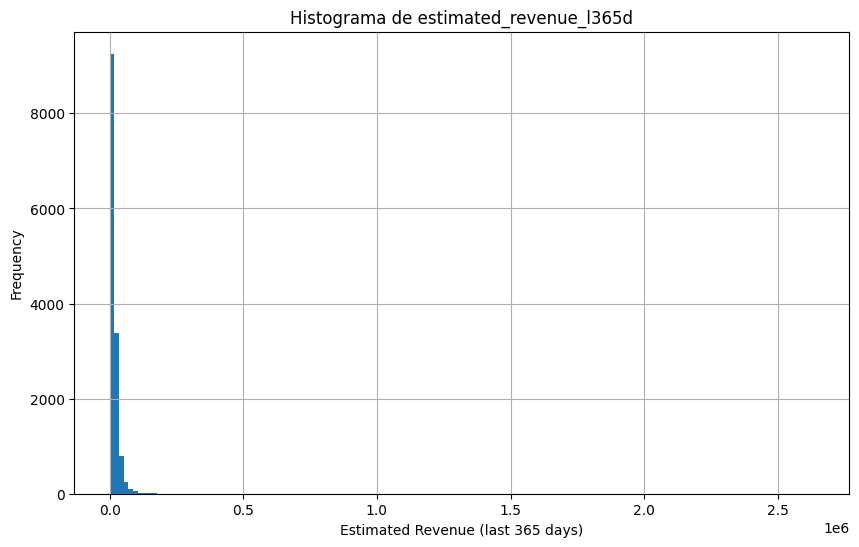

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
df['estimated_revenue_l365d'].dropna().hist(bins=150)
plt.xlabel('Estimated Revenue (last 365 days)')
plt.ylabel('Frequency')
plt.title('Histograma de estimated_revenue_l365d')
plt.show()